<a href="https://colab.research.google.com/github/giacomo-cgn/RBM-MNIST/blob/main/rbm_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




# RBM for MNIST encoding

Giacomo Cignoni - 581112

1.     The RBM is trained with a single layer of hidden neurons on the MNIST data.

2.     Use the trained RBM to encode all the MNIST images using the corresponding activation of the hidden neurons.

3.     A simple classifier is trained to recognize the MNIST digits using as inputs their encoding obtained at step 2.

# Preparations

Base necessary imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt

# Dataset



The MNIST dataset (60000 tr images and 10000 test 28x28 images) is imported using Keras library for simplicity.



In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist

The MNIST dataset images are in grayscale (each pixel has value 0-255). The values in the corrsponding image array are scaled to the 0-1 range and then thresholded at 0.5, so to obtain a binary image for each pattern. Binary images allows to use the image pixels directly as values of the RBM visble units, hopefully without compromising the image due to the simple nature of the patterns.
Finally, the each image pattern bidimensional array is flattened to a monodimensional array with length 784.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.around(x_train/255, decimals=0).astype('int')
x_test = np.around(x_test/255, decimals=0).astype('int')


x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print('Train shape:',np.shape(x_train))
print('Test shape:',np.shape(x_test))

11501568/11490434 [==============================] - 0s 0us/step
Train shape: (60000, 784)
Test shape: (10000, 784)


The utility function defining the sigmoid (applicable to numpy array) is defined

In [ ]:
def sigmoid(x):
  return 1./(1 + np.exp(-x))

This utility function return the probability of each binary feature of a dataset be active (to be == 1) in said dataset.

In [ ]:
def extract_activation_prob(tr_input):
  occurrencies = np.sum(tr_input, axis=0, dtype=np.single) #calculates occurrencies in tr_set for each visible unit
  res = occurrencies / tr_input.shape[0] #return probability of activation of each visible unit in the tr set
  return res

# RBM

A RBM class was declared with train method, to train weight and biases, and a predict method, to get the hidden unit activation from sampled input data.
For building the model the guide http://www.cs.toronto.edu/~hinton/absps/guideTR.pdf was followed (will refer to it as [1]); also the MATLAB code in http://www.cs.toronto.edu/~hinton/code/rbm.m was used as guideline.

The approach used for training weights and bias is CD-1, as seen at lesson.

Here is presented a list of the implemented features of the RBM with a brief explanation of implementation choices.


*   **Weights initialization:** as suggested in [1], initialweights were drawn from a gaussian with centre=0 and std=0.01
*   **Visible bias initialization:** as suggested in [1], it is initialized with the function *log(p/(1-p))* with p being the previously defined *extract_activation_prob*, and then clipped in [-0.1, 0.1] range to avoid infinites
*   **Hidden bias initialization:** initialized to 0 as suggested in [1]
*   **Batch size:** as suggested in [1] it is of the same size of the number of classes (if small), in our case 10
*   **Reconstructed data:** in the data reconstruction step in CD-1, sampling the reconstructed data probabilities is not necessary, the option to abilitate sampling for this step was implemented




In [ ]:
class RBM:
  def __init__(self, lr, num_visible, num_hidden, batch_size=10, sample_rec_data=True):
    self.lr = lr
    self.num_visible = num_visible
    self.num_hidden = num_hidden
    self.batch_size = batch_size
    self.sample_rec_data = sample_rec_data

    self.weights = np.random.normal(loc=0, scale=0.01, size=(self.num_visible, self.num_hidden))
    self.hid_bias = np.zeros((self.num_hidden))

  def train(self, input, target, epochs=15):
    p = extract_activation_prob(input)
    self.vis_bias = np.log(p/(1-p))
    self.vis_bias = np.clip(self.vis_bias, -0.1, 0.1)

    num_batches = math.ceil(input.shape[0]/self.batch_size)
    batches_list = [input[self.batch_size*y : self.batch_size*(y+1), :] for y in range(num_batches)]

    for e in range(epochs):
      sum_err = 0
      for b in batches_list:
        data = b  # data shape = [batch_size, num_vis]

        # Wake part, positive

        pos_hid_probs = sigmoid(np.matmul(data, self.weights) + self.hid_bias)  # Hidden activation probability
        # pos_hid_probs shape = [batch_size, num_hid]

        wake = np.matmul(data.T, pos_hid_probs)
        # wake shape = [num_vis, num_hid]

        pos_hid_states = pos_hid_probs > np.random.rand(self.batch_size, self.num_hidden) # Stochastic hidden activation

        # Dream part, negative

        recon_data_probs = sigmoid(np.matmul(pos_hid_states, self.weights.T + self.vis_bias))  # Data reconstruction probability
        # recon_data_probs shape = [batch_size, num_vis]

        if self.sample_rec_data:
          recon_data = recon_data_probs > np.random.rand(self.batch_size, self.num_visible)   # Stochastic reconstructed data
        else:
          recon_data = recon_data_probs # Do not sample reconstructed data

        neg_hid_probs = sigmoid(np.matmul(recon_data, self.weights) + self.hid_bias)
        # neg_hid_probs shape = [batch_size, num_hid]

        dream = np.matmul(recon_data.T, neg_hid_probs) 
        # dream shape = [num_vis, num_hid]

        # Weights and biases deltas
        delta_weights = (wake - dream ) / self.batch_size 
        delta_bias_hid = (np.sum(pos_hid_probs, axis=0) - np.sum(neg_hid_probs, axis=0)) / self.batch_size
        delta_bias_vis = (np.sum(data, axis=0) - np.sum(recon_data, axis=0)) / self.batch_size

        # Updates
        self.weights += self.lr*delta_weights
        self.hid_bias += self.lr*delta_bias_hid
        self.vis_bias += self.lr*delta_bias_vis

        # Error
        err = np.sum(data - recon_data) ** 2
        #print('Batch err:', err)
        sum_err += err

      print('Epoch', e, '- err:', sum_err)


  def predict(self, input):
    # hid_probs shape = [num_patterns, num_hid]

    hid_probs = sigmoid(np.matmul(input, self.weights) + self.hid_bias)  # Hidden activation probability
    return hid_probs

      

After a few preliminary trials, a relatively low learning rate of 0.001 was chosen (as regularization was not implemented in the model) and also a number of 100 hidden states to execute training

In [ ]:
learning_rate = 0.001
hid_units_num = 100

A first RBM `rbm1` was trained with sampling after data reconstruction

In [ ]:
rbm1 = RBM(learning_rate, x_train.shape[1], hid_units_num, sample_rec_data=True)
rbm1.train(x_train, y_train)

hid_probs_train1 = rbm1.predict(x_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Epoch 0 - err: 282832561
Epoch 1 - err: 381663397
Epoch 2 - err: 220886356
Epoch 3 - err: 176086700
Epoch 4 - err: 182924855
Epoch 5 - err: 199535280
Epoch 6 - err: 221485440
Epoch 7 - err: 233813287
Epoch 8 - err: 233163426
Epoch 9 - err: 228737488
Epoch 10 - err: 225698615
Epoch 11 - err: 220700971
Epoch 12 - err: 219692895
Epoch 13 - err: 217586590
Epoch 14 - err: 215966733


A second RBM `rbm2` was trained without sampling after data reconstruction

In [ ]:
rbm2 = RBM(learning_rate, x_train.shape[1], hid_units_num, sample_rec_data=False)
rbm2.train(x_train, y_train)

hid_probs_train2 = rbm2.predict(x_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


Epoch 0 - err: 295033179.4089149
Epoch 1 - err: 343006739.4575792
Epoch 2 - err: 208163267.8998438
Epoch 3 - err: 175326132.371156
Epoch 4 - err: 164354325.0901653
Epoch 5 - err: 163476793.66887632
Epoch 6 - err: 161077313.29608476
Epoch 7 - err: 162093191.5229246
Epoch 8 - err: 160915901.96749467
Epoch 9 - err: 162953672.49890006
Epoch 10 - err: 164941788.5053842
Epoch 11 - err: 167742746.8214331
Epoch 12 - err: 173503362.16053918
Epoch 13 - err: 179582826.4972485
Epoch 14 - err: 184145057.03719443


Let's now show the weights relative to 10 hidden units of the 100 total. This “receptive” fields are relavant because they show which regions of the image activate more the respective hidden unit.

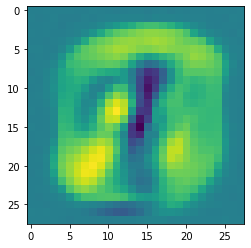

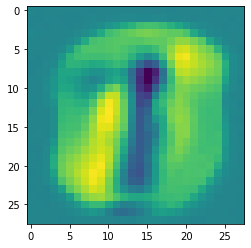

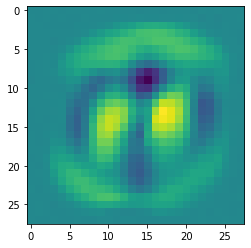

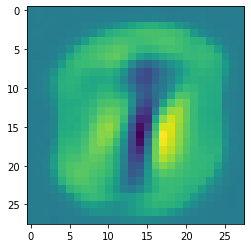

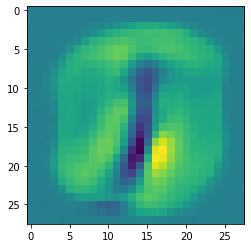

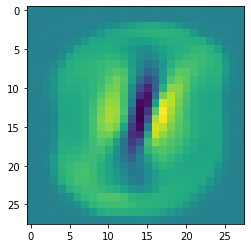

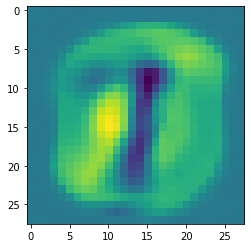

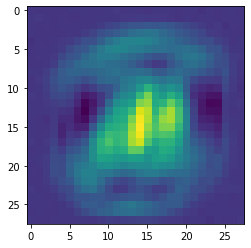

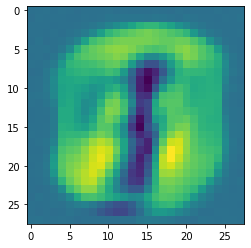

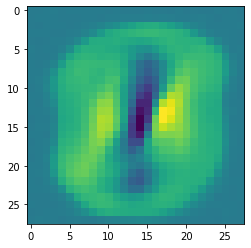

In [ ]:
for i in range(int(hid_units_num/10)):
  plt.imshow(rbm1.weights[:,i*10].reshape(28,28))
  plt.show()

# Simple classifier

The simple classifier chosen is an SVM, implemented through Sklearn. It has an RBF kernel, regularization C=2.0 and gamma set to 'scale' (1/(n_features*X.var())).

2 SVMs are trained, 1 for `rbm1` and one for `rbm2`.

Classification accuracy of the image numbers is the chosen performance and is calculated calculated for both explored models.

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# SVM for RBM with recon data sampling
svm1 = SVC(kernel="rbf", C=2.0, gamma='scale')
svm1.fit(hid_probs_train1, y_train)

y_train_pred_1 = svm1.predict(hid_probs_train1)
acc_tr_1 = accuracy_score(y_train, y_train_pred_1)
print("Training accuracy (with reconstruction sampling)", acc_tr_1)

# SVM for RBM without recon data sampling
svm2 = SVC(kernel="rbf", C=2.0, gamma='scale')
svm2.fit(hid_probs_train2, y_train)

y_train_pred_2 = svm2.predict(hid_probs_train2)
acc_tr_2 = accuracy_score(y_train, y_train_pred_2)
print("Training accuracy (without reconstruction sampling)", acc_tr_2)

Training accuracy (with reconstruction sampling) 0.8651666666666666
Training accuracy (without reconstruction sampling) 0.8675


Accuracy on training was not exceptional, although somewhat good. This could be caused by the possible loss of information for the input data provoked by the initial thresholding, or by not enough optimized RBM parameters.

Difference in accuracy between sammpled and non-sampled reconstruction data is minimal, proving as explained in [1], that it does not change much the RBM behaviour.

# Test

In [ ]:
hid_probs_test_1 = rbm1.predict(x_test) # RBM with recon data sampling
hid_probs_test_2 = rbm2.predict(x_test) # RBM without recon data sampling

# SVM for RBM with recon data sampling
y_test_pred_1 = svm1.predict(hid_probs_test_1)
acc_ts_1 = accuracy_score(y_test, y_test_pred_1)
print("Test accuracy (with reconstruction sampling)", acc_ts_1)

# SVM for RBM without recon data sampling
y_test_pred_2 = svm2.predict(hid_probs_test_2)
acc_ts_2 = accuracy_score(y_test, y_test_pred_2)
print("Test accuracy (without reconstruction sampling)", acc_ts_2)

Test accuracy (with reconstruction sampling) 0.8536
Test accuracy (without reconstruction sampling) 0.8627


The results of the test set closely adhere to the results on training, proving that the model does not fall into overfitting.
A slight difference on test accuracy exists between the RBM with sampled reconstruction data and the one without, slightly in favour of the RBM trained without sampling over reconstructed data.